## **Import libs:**

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision.tv_tensors import Image, Mask
from torchvision.datasets import OxfordIIITPet
import torchvision.transforms.v2 as T
from tqdm import tqdm

In [21]:
EPOCHS = 100
BATCHSIZE = 2 # Further reduced batch size to mitigate OutOfMemoryError
LR = 1e-5 # Further reduced learning rate for stability


## **Check Gpu:**

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## **Architecture:**

Pax merging is the equivalent to MaxPool 2x2 is the Unet.
I divide the input as an image composed by 4x4 patches.
I want to create a image composed by 2x2 patches, so I need to reshape.

x.reshape(B, H // 2, 2, W // 2, 2, C) give us (B, H // 2, 2, W // 2, 2, C), but I want B, H//2, W//2, 2C... I need to permute, so I have: B, H//2, W//2, 2, 2, C.
After that, I need to reshape to have B, H//2, W//2, 4C, and I need a reducton to have B, H//2, W//2, 2C



In [23]:
class PatchMerging(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.norm = nn.LayerNorm(dim * 4)
        self.reduction = nn.Linear(dim * 4, 2*dim, bias = False)

    def forward(self, x):
        B, H, W, C = x.shape
        x = x.reshape(B, H // 2, 2, W // 2, 2, C).permute(0, 1, 3, 2, 4, 5).reshape(B, H // 2, W // 2, 4 * C)
        x = self.norm(x)
        x = self.reduction(x)
        return x

We also need the equivalent of Upsampling: Patch Expanding...

In [24]:
class PatchExpanding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.expand = nn.Linear(2 * dim, 4 * dim, bias = False)
        self.norm = nn.LayerNorm(dim)

    def forward(self, x):
        # x = B, H /2, W/2, 2C
        x = self.expand(x)
        # x = B, H/2, W/2, 4C
        B, semiH, semiW, Cx4 = x.shape
        x = x.view(B, semiH, semiW, 2, 2, Cx4 // 4)
        # x = B, H/2, W/2, 2, 2, 4C/4
        x = x.permute(0, 1, 3, 2, 4, 5)
        # x = B, H/2, 2, W/2, 2, 4C/4
        x = x.reshape(B, semiH *2 , semiW * 2,Cx4 // 4)
        # x = B, H, W, 4C/4
        x = self.norm(x)
        return x # B, H, W, C

One of the assets of swin unet, it's this capacity of create tokens from the input, using windows, and doing attention on fixed windows W-MSA vs on swift windows SW-MSA

In [25]:
def window_partition(x, window_size):
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows

def window_reverse(windows, window_size, H, W):
    C = windows.shape[-1]
    x = windows.view(-1, H //window_size, W // window_size, window_size, window_size, C)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, H, W, C)
    return x

def get_relative_position_index(window_size, device = None):
    coords_h = torch.arange(window_size, device= device, dtype=torch.long)
    coords_w = torch.arange(window_size, device= device, dtype=torch.long)
    coords = torch.stack(torch.meshgrid([coords_h, coords_w], indexing="ij"))  # 2, Wh, Ww
    coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
    relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
    relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
    relative_coords[:, :, 0] += window_size - 1  # shift to start from 0
    relative_coords[:, :, 1] += window_size - 1
    relative_coords[:, :, 0] *= 2 * window_size - 1
    relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
    return relative_position_index


class WindowAttention(nn.Module):
    def __init__(self, dim, window_size, num_heads, qkv_bias=True, attn_drop=0., proj_drop=0.):
        super().__init__()
        assert dim % num_heads == 0, "dim should be divisible by num_heads"
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        self.register_buffer("relative_position_index",  get_relative_position_index(window_size))
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size - 1) * (2 * window_size - 1), num_heads)
        )

        nn.init.trunc_normal_(self.relative_position_bias_table, std=.02)

    def forward(self, x, mask=None):
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            N, N, -1)
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = F.softmax(attn, dim=-1)
        else:
            attn = F.softmax(attn, dim=-1)

        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


Swin Transformer block:

In [26]:
class SwinTransformerBlock(nn.Module):
    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0, mlp_ratio=4., qkv_bias=True, drop=0., attn_drop=0., drop_path=0.):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio

        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.norm1 = nn.LayerNorm(dim)
        self.attn = WindowAttention(dim, window_size, num_heads, qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop)
        self.norm2 = nn.LayerNorm(dim)

        self.drop_path = nn.Identity() if drop_path == 0. else nn.Dropout(drop_path)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_hidden_dim),
            nn.GELU(),
            nn.Dropout(drop),
            nn.Linear(mlp_hidden_dim, dim),
            nn.Dropout(drop)
        )

        if shift_size > 0:
            self.register_buffer("attention_mask", self.compute_mask(*input_resolution, device = "cpu"))
        else:
            self.attention_mask = None

    def compute_mask(self, H, W, device = None):
        img_mask = torch.zeros((1, H, W, 1), device=device)
        h_slices = (slice(0, -self.window_size),
                    slice(-self.window_size, -self.shift_size),
                    slice(-self.shift_size, None))
        w_slices = (slice(0, -self.window_size),
                    slice(-self.window_size, -self.shift_size),
                    slice(-self.shift_size, None))
        cnt = 0
        for h in h_slices:
            for w in w_slices:
                img_mask[:, h, w, :] = cnt
                cnt += 1

        mask_windows = window_partition(img_mask, self.window_size)
        mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
        attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
        attn_mask = attn_mask.masked_fill(attn_mask != 0, float("-inf")).masked_fill(attn_mask == 0, float(0.0))
        return attn_mask

    def forward(self, x):
        if self.attention_mask is not None:
            self.attention_mask = self.attention_mask.to(x.device)
        B, H, W, C = x.shape
        shortcut = x

        x = self.norm1(x)
        if self.shift_size > 0:
            x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        x_windows = window_partition(x, self.window_size)
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)

        attn_windows = self.attn(x_windows, mask=self.attention_mask)
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)

        x = window_reverse(attn_windows, self.window_size, H, W)
        if self.shift_size > 0:
            x = torch.roll(x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))

        x = shortcut + x
        x = x + self.mlp(self.norm2(x))
        return x


Swin Transformer (W-MWSA & SW-MSA):

In [27]:
class Encoder(nn.Module):
    def __init__(self, dim, input_resolution, depth, num_heads, window_size=7):
        super().__init__()
        self.blocks = nn.ModuleList(
            [SwinTransformerBlock(dim=dim,
                                  input_resolution=input_resolution,
                                  num_heads=num_heads,
                                  window_size=window_size,
                                  shift_size=0 if (i % 2 == 0) else window_size // 2,
                                  mlp_ratio=4.,
                                  qkv_bias=True,
                                  drop=0.,
                                  attn_drop=0.,
                                  drop_path=0.) for i in range(depth)])
        self.downsample = PatchMerging(dim)

    def forward(self, x):
        for blk in self.blocks:
            x = blk(x)
        skip_connections = x
        x = self.downsample(x)
        return x, skip_connections

class Decoder(nn.Module):
    def __init__(self, dim, input_resolution, depth, num_heads, window_size=7):
        super().__init__()
        self.upsample = PatchExpanding(dim)
        self.fusin = nn.Linear(2 * dim, dim)
        self.blocks = nn.ModuleList(
            [SwinTransformerBlock(dim=dim,
                                  input_resolution=input_resolution,
                                  num_heads=num_heads,
                                  window_size=window_size,
                                  shift_size=0 if (i % 2 == 0) else window_size // 2,
                                  mlp_ratio=4.,
                                  qkv_bias=True,
                                  drop=0.,
                                  attn_drop=0.,
                                  drop_path=0.) for i in range(depth)])
    def forward(self, x, skip_connections):
        x = self.upsample(x)
        x = torch.cat((x, skip_connections), -1)
        x = self.fusin(x)
        for blk in self.blocks:
            x = blk(x)
        return x

In [28]:
class PatchEmbed(nn.Module):
    def __init__(self, img_size=512, patch_size=2, in_chans=3, embed_dim=96):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.in_chans = in_chans
        self.embed_dim = embed_dim
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.proj(x)
        x = x.permute(0, 2, 3, 1).contiguous()
        x = self.norm(x)
        return x


class SwinUnet(nn.Module):
    def __init__(self, img_size = 256, in_chans=3, num_classes=3, embed_dim=96, depths=[2,2,2,2], patch_size=2, num_heads=[3,6,12,24], window_size=8): # Changed window_size to 8 and num_classes to 3
        super().__init__()
        self.patch_embed = PatchEmbed(img_size=img_size, patch_size = patch_size, in_chans=in_chans, embed_dim=embed_dim)
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        self.dim = embed_dim

        dim = embed_dim
        resolution = img_size // patch_size
        for i in range(len(depths)):
            self.encoder.append(Encoder(dim=dim, input_resolution=(resolution, resolution), depth=depths[i], num_heads=num_heads[i], window_size=window_size))
            dim *= 2
            resolution = resolution // 2

        # Fix: The bottleneck should use the full 'dim' (1536) from the last encoder, not dim // 2
        self.bottleneck = nn.Sequential(*[SwinTransformerBlock(dim=dim, # Changed from dim//2 to dim
                                                               input_resolution=(resolution, resolution),
                                                               num_heads=num_heads[-1],
                                                               window_size=window_size,
                                                               shift_size= window_size // 2,
                                                               mlp_ratio=4.,
                                                               qkv_bias=True,
                                                               drop=0.,
                                                               attn_drop=0.,
                                                               drop_path=0.) for i in range(depths[-1])])
        self.decoder = nn.ModuleList()
        for i in reversed(range(len(depths))):
            dim = dim // 2
            resolution = resolution * 2
            self.decoder.append(Decoder(dim=dim, input_resolution=(resolution, resolution), depth=depths[i], num_heads=num_heads[i], window_size=window_size))

        self.head = nn.Conv2d(embed_dim, num_classes, kernel_size=1)
        self.final_upsample = nn.Upsample(
            scale_factor=patch_size,
            mode="bilinear",
            align_corners=False
        )



    def forward(self, x):
        x = self.patch_embed(x)
        skip_connections = []
        for enc in self.encoder:
            x, skip = enc(x)
            skip_connections.append(skip)
        x = self.bottleneck(x)
        for i, dec in enumerate(self.decoder):
            skip = skip_connections[-(i+1)]
            x = dec(x, skip)
        x = x.permute(0, 3, 1, 2).contiguous()
        x = self.head(x)
        x = self.final_upsample(x)
        return x



model = SwinUnet().to(device)

# If already trained, load weights
model.load_state_dict(torch.load("C:/Users/doyez/OneDrive/Documents/projects/repo_from_github/ComputerVisionDeepLearning/models_saved/monoclass/best_swinunet.pth"))
print(model)


C:\Users\doyez\AppData\Local\Temp\ipykernel_27416\1242657890.py:80: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("C:/Users/doyez/OneDrive/D

SwinUnet(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(2, 2), stride=(2, 2))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (encoder): ModuleList(
    (0): Encoder(
      (blocks): ModuleList(
        (0-1): 2 x SwinTransformerBlock(
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (drop_path): Identity()
          (mlp): Sequential(
            (0): Linear(in_features=96, out_features=384, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=384, out_features=9

## **DataGenerator:**

In [29]:
train_transform = T.Compose([
    T.Resize((256, 256)),
    T.RandomHorizontalFlip(p = 0.5),
    T.RandomRotation(degrees = 15),
])

val_transform = T.Compose([
    T.Resize((256, 256)),
])

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import OxfordIIITPet
import torchvision.transforms.v2 as T



class OxfordPetSegmentation(Dataset):
    def __init__(self, root, split = "trainval", transforms = None):
        self.dataset = OxfordIIITPet(root=root, download=True, split = split, target_types = ["segmentation", "category"])
        self.transforms = transforms
        self.classes = self.dataset.classes

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, (mask, label) = self.dataset[idx]

        mask_np = np.array(mask)
        animal_pixels = (mask_np == 1)

        multiclass_mask = np.zeros_like(mask_np, dtype=np.uint8)
        multiclass_mask[animal_pixels] = 1

        image_dp = Image(image)
        mask_dp = Mask(multiclass_mask)

        # Apply geometric transforms to datapoints
        if self.transforms:
            # Transforms that work on (dp.Image, dp.Mask) will keep them synchronized
            image_dp, mask_dp = self.transforms(image_dp, mask_dp)

        image_tensor = T.ToDtype(torch.float32, scale=True)(image_dp)
        mask_tensor = torch.as_tensor(mask_dp, dtype=torch.long)

        return image_tensor, mask_tensor


In [31]:
train_datset = OxfordPetSegmentation(root = "data", split = "trainval", transforms = train_transform)
val_datset = OxfordPetSegmentation(root = "data", split = "test", transforms = val_transform)

In [32]:
img, mask = train_datset[0]
print(img.shape)    # [3, 512, 512]
print(mask.shape)   # [512, 512]
print(torch.unique(mask))  # tensor([0, 1, 2])


torch.Size([3, 256, 256])
torch.Size([256, 256])
tensor([0, 1])


On my windows computer, I have to take 0 workers

In [33]:
train_loader = DataLoader(train_datset, batch_size = BATCHSIZE, shuffle = True, num_workers= 0)
val_loader = DataLoader(val_datset, batch_size = BATCHSIZE, shuffle = True, num_workers= 0)

## **Training:**

In [34]:
# Loss: CrossEntropyLoss
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [35]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0

    pbar = tqdm(dataloader, desc="Train", leave = False)
    for images, masks in pbar:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pbar.set_postfix({"loss": loss.item()})
    return running_loss / len(dataloader)

In [36]:
def compute_confusion(preds, targets, class_id):
    """
    preds, targets: [B, H, W] torch tensors
    class_id: int (1=cat, 2=dog)
    """
    preds_c = preds == class_id
    targets_c = targets == class_id

    tp = (preds_c & targets_c).sum().item()
    fp = (preds_c & ~targets_c).sum().item()
    fn = (~preds_c & targets_c).sum().item()

    return tp, fp, fn



def precision_recall_f1_iou(tp, fp, fn, eps=1e-8):
    precision = tp / (tp + fp + eps)
    recall    = tp / (tp + fn + eps)
    f1        = 2 * precision * recall / (precision + recall + eps)
    iou       = tp / (tp + fp + fn + eps)
    return precision, recall, f1, iou


In [37]:
@torch.no_grad()
def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0

    stats = {
        "animal" : {"tp": 0, "fp": 0, "fn": 0}
    }


    for images, masks in dataloader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)

        running_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        tp, fp, fn = compute_confusion(preds, masks, class_idx + 1) # Because class are 1 and 2
        stats["animal"]["tp"] += tp
        stats["animal"]["fp"] += fp
        stats["animal"]["fn"] += fn
    metrics = {}
    tp = stats["animal"]["tp"]
    fp = stats["animal"]["fp"]
    fn = stats["animal"]["fn"]

    precision, recall, f1, iou = precision_recall_f1_iou(tp, fp, fn, eps = 1e-8)
    metrics["animal"] = {
    "precision": precision,
    "recall": recall,
    "f1": f1,
    "iou": iou,
    }
    return running_loss / len(dataloader), metrics

In [39]:
best_iou = 0.0

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_metrics = validate_one_epoch(model, val_loader, criterion, device)
    mean_iou = (
        val_metrics["animal"]["iou"]
    ) 

    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val   Loss: {val_loss:.4f}")
    print(
        f"Mean IoU: {mean_iou:.3f} | "
        f"Animal IoU: {val_metrics['animal']['iou']:.3f}"
    )

    for cls in ["animal"]:
        m = val_metrics[cls]
        print(
            f"{cls.upper()} → "
            f"P: {m['precision']:.3f} "
            f"R: {m['recall']:.3f} "
            f"F1: {m['f1']:.3f}"
        )

    if mean_iou > best_iou:
        best_iou = mean_iou
        torch.save(model.state_dict(),  "C:/Users/doyez/OneDrive/Documents/projects/repo_from_github/ComputerVisionDeepLearning/models_saved/monoclass/best_swinunet.pth")
        print("Best model saved")


torch.save(model.state_dict(), "C:/Users/doyez/OneDrive/Documents/projects/repo_from_github/ComputerVisionDeepLearning/models_saved/monoclass/final_swinunet.pth")

model.load_state_dict(torch.load("C:/Users/doyez/OneDrive/Documents/projects/repo_from_github/ComputerVisionDeepLearning/models_saved/monoclass/best_swinunet.pth"))
model.eval()

Epoch 1/100


KeyboardInterrupt: 

## **Testing:**

In [40]:
def compute_metrics_binary(pred, target):
    pred = pred.bool()
    target = target.bool()

    tp = (pred & target).sum().item()
    fp = (pred & ~target).sum().item()
    fn = (~pred & target).sum().item()

    precision = tp / (tp + fp + 1e-8)
    recall    = tp / (tp + fn + 1e-8)
    f1        = 2 * precision * recall / (precision + recall + 1e-8)
    iou       = tp / (tp + fp + fn + 1e-8)

    return precision, recall, f1, iou


In [41]:
from matplotlib import pyplot as plt
import torch


@torch.no_grad()
def testing(model, dataloader, device, num_batches=1):
    model.eval()

    metrics = {
        "animal": {"precision": [], "recall": [], "f1": [], "iou": []},
    }

    for batch_idx, (imgs, masks) in enumerate(dataloader):
        if batch_idx >= num_batches:
            break

        imgs = imgs.to(device)
        masks = masks.to(device)

        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1)

        imgs = imgs.cpu()
        masks = masks.cpu()
        preds = preds.cpu()

        for i in range(imgs.size(0)):
            img = imgs[i].permute(1, 2, 0)
            gt = masks[i]
            pr = preds[i]

            # ===== Metrics =====
            # Animal = class 1
            p, r, f1, iou = compute_metrics_binary(pr == 1, gt == 1)
            metrics["animal"]["precision"].append(p)
            metrics["animal"]["recall"].append(r)
            metrics["animal"]["f1"].append(f1)
            metrics["animal"]["iou"].append(iou)

            # ===== Plot =====
            fig, axs = plt.subplots(2, 2, figsize=(12, 8))
            fig.suptitle(
                f"Sample {i} | "
                f"Animal IoU: {metrics['animal']['iou'][-1]:.3f}",
                fontsize=14
            )

            axs[0, 0].imshow(img)
            axs[0, 0].set_title("Input Image")
            axs[0, 0].axis("off")

            axs[0, 1].imshow(gt == 1, cmap="gray")
            axs[0, 1].set_title("GT - Animal")
            axs[0, 1].axis("off")

            axs[1, 1].imshow(pr == 1, cmap="gray")
            axs[1, 1].set_title("Pred - Animal")
            axs[1, 1].axis("off")

            axs[1, 0].axis("off")
            plt.tight_layout()
            plt.show()

    # ===== Aggregate results =====
    print("\n===== FINAL METRICS =====")
    for cls in ["animal"]:
        print(f"\nClass: {cls}")
        for m in metrics[cls]:
            print(f"{m}: {sum(metrics[cls][m]) / len(metrics[cls][m]):.4f}")


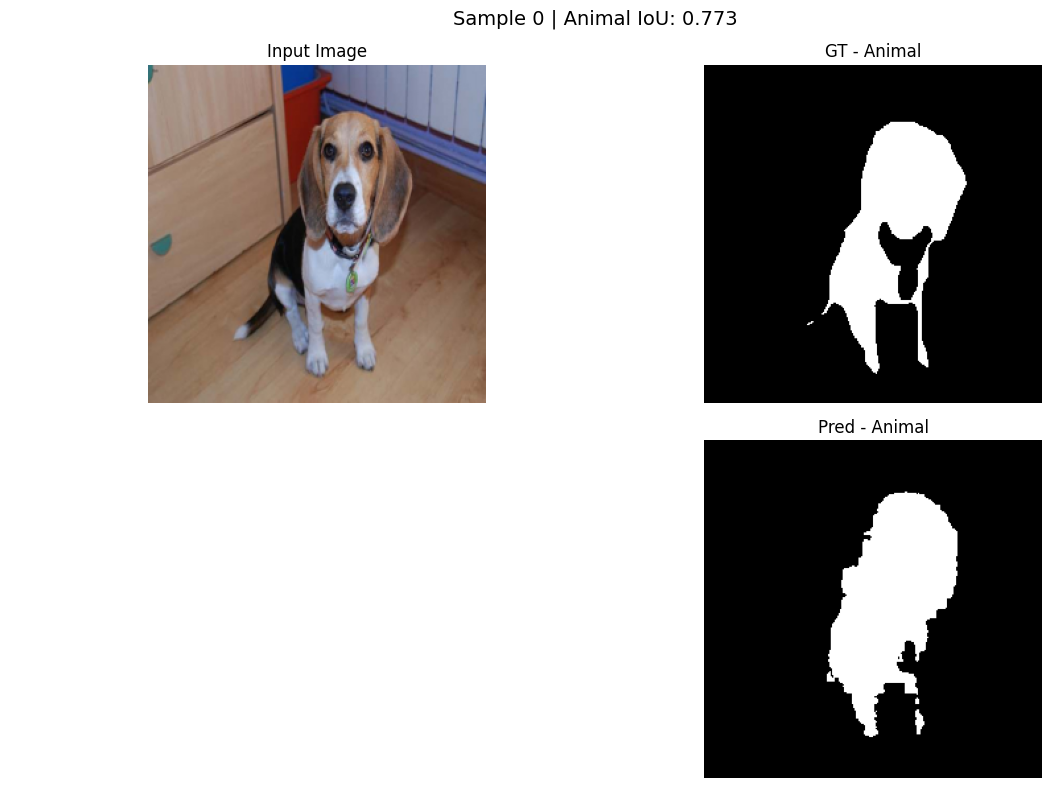

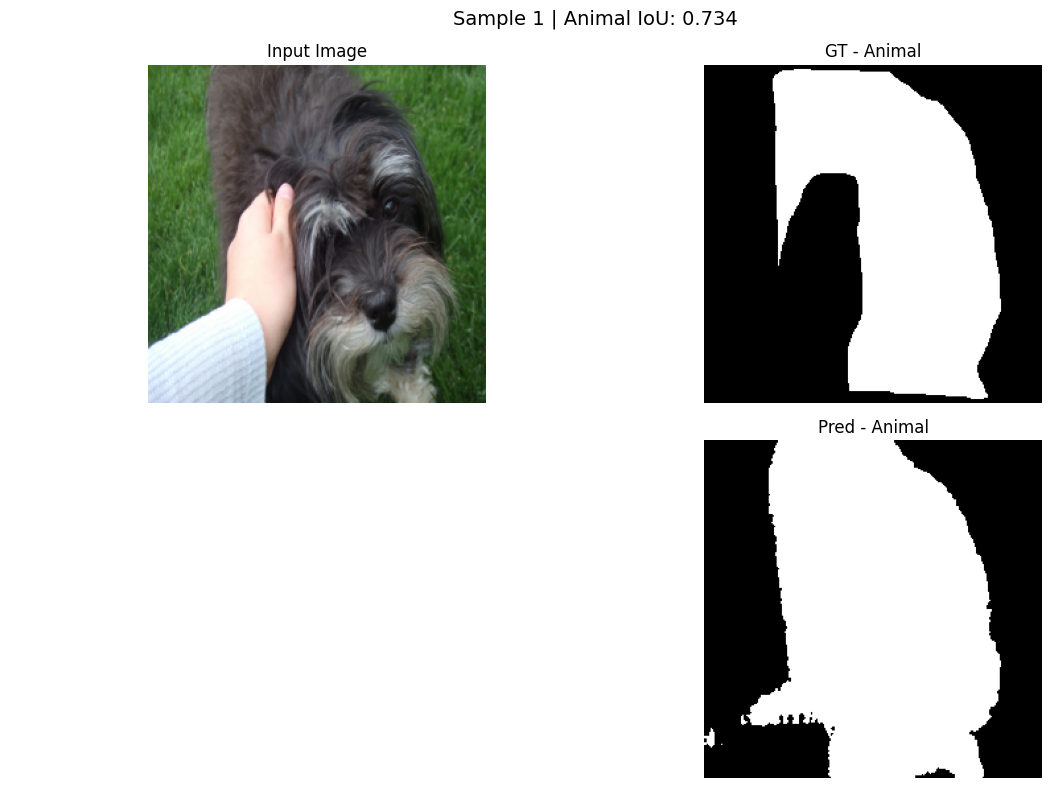

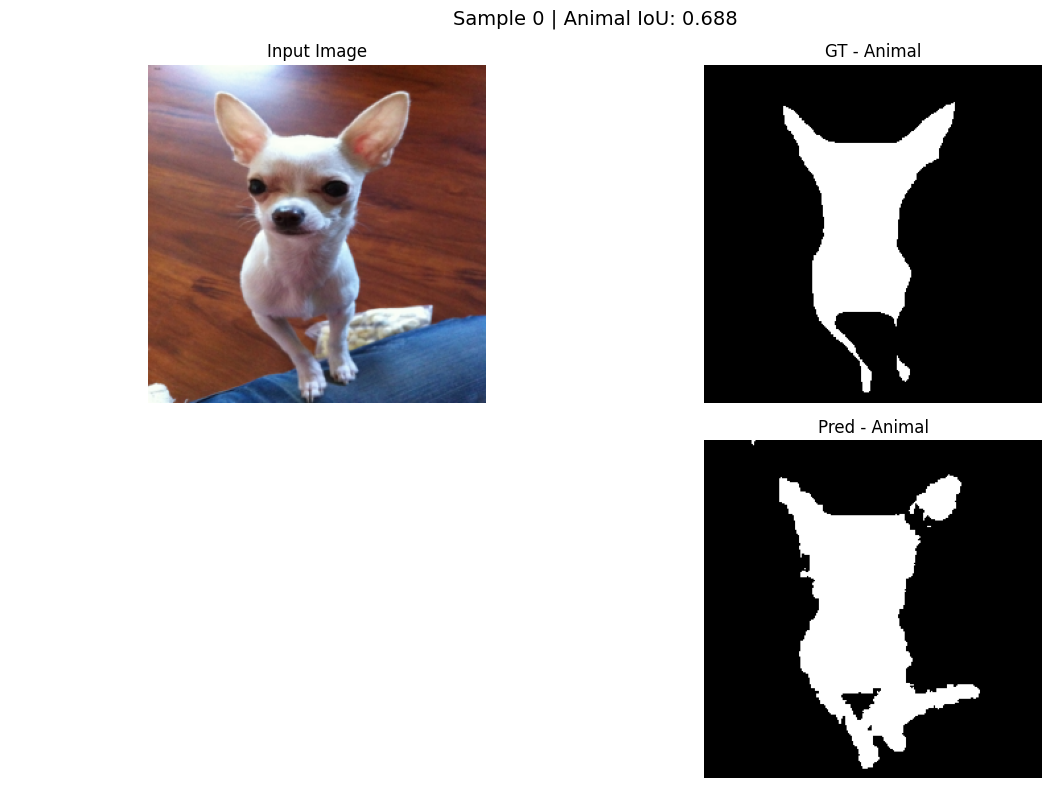

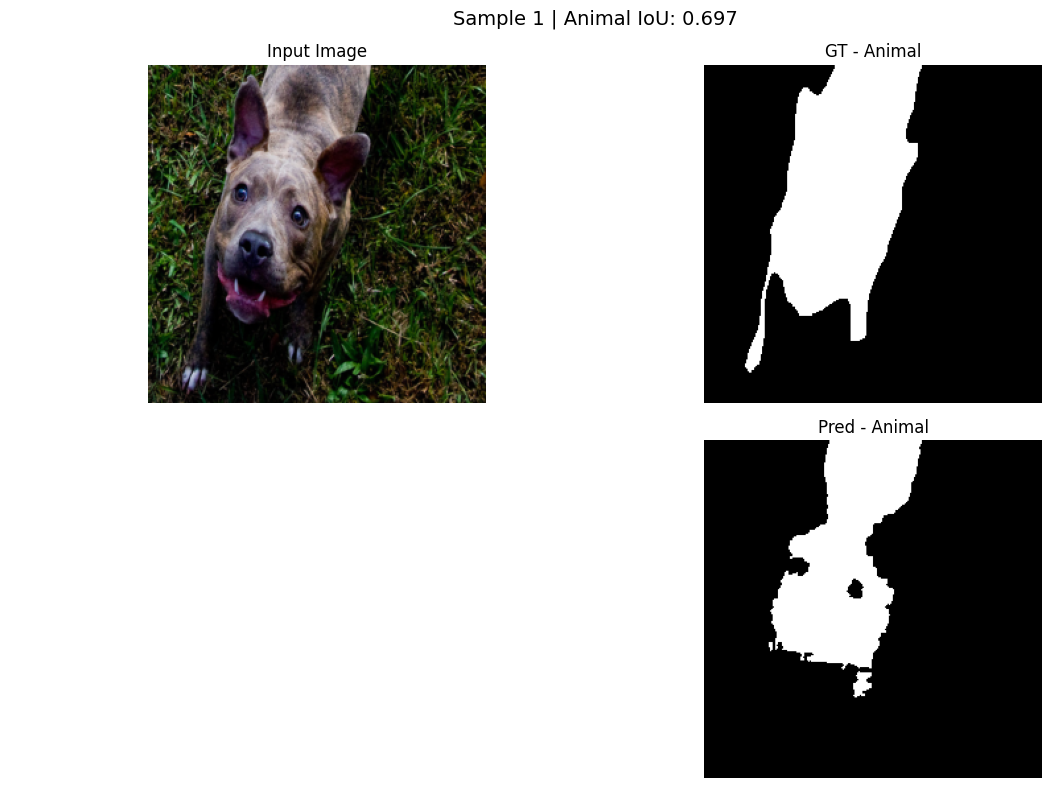


===== FINAL METRICS =====

Class: animal
precision: 0.8171
recall: 0.8912
f1: 0.8388
iou: 0.7230


In [42]:
testing(model, val_loader, device, num_batches=2)